In [345]:
# Modify environment variables accordingly
%set_env ENV_DRIVE_WEIGHTS_RELPATH=MyDrive/Motorage/AnnotatedLicensePlates
%set_env ENV_BASE_DRIVE_ABSPATH=/content/drive
%set_env ENV_WEIGHTS_ABSPATH=/content/weights

env: ENV_DRIVE_WEIGHTS_RELPATH=MyDrive/Motorage/AnnotatedLicensePlates
env: ENV_BASE_DRIVE_ABSPATH=/content/drive
env: ENV_WEIGHTS_ABSPATH=/content/weights


In [2]:
#!cp --help
!mkdir -p $ENV_WEIGHTS_ABSPATH
!cp -r $ENV_BASE_DRIVE_ABSPATH/$ENV_DRIVE_WEIGHTS_RELPATH $ENV_WEIGHTS_ABSPATH

In [3]:
import cv2, os, torch, re, imutils
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np

In [4]:
!pip install --quiet easyocr

     |████████████████████████████████| 63.6 MB 59 kB/s 
     |████████████████████████████████| 47.7 MB 1.5 MB/s 


In [5]:
import easyocr

In [6]:
WEIGHTS_FILE_PATH = input("Enter weights path\n")
assert os.path.exists(WEIGHTS_FILE_PATH), "Path provided does not exist"

Enter weights path
/content/weights/AnnotatedLicensePlates/weights.pt


# Load custom pretrained YOLOv5 model

In [ ]:
# Load up pretrained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', model='custom', path=WEIGHTS_FILE_PATH)
model.max_det = 1
model.conf = 0.5

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


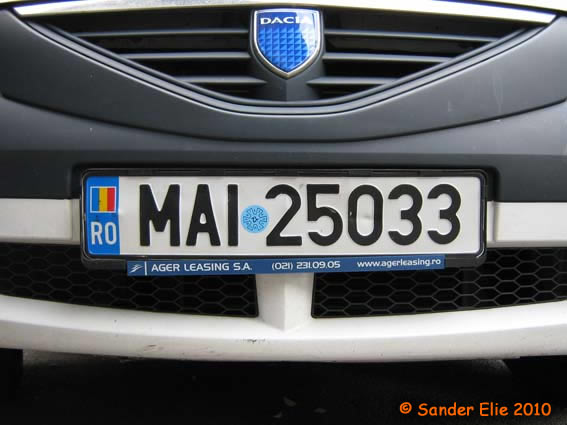

In [335]:
IMAGE_FILE_PATH = input("Enter image path\n")
assert os.path.exists(IMAGE_FILE_PATH), "Path provided does not exist"

image = Image.open(IMAGE_FILE_PATH)

inference_result, *_ = model(image).xyxy
image

In [336]:
assert len(inference_result) > 0, "Could not detect license plate"
plate_coords = inference_result.numpy()[0, :4]
plate_coords

array([      78.44,      171.26,      492.79,      257.27], dtype=float32)

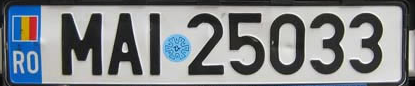

In [346]:
license_plate = image.crop(plate_coords)
license_plate

#Load OCR model

In [11]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Download complete


Download complete.


In [12]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def remove_noise(image, kernel):
    return cv2.medianBlur(image, kernel)

def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def dilate(image, kernel_shape):
    kernel = np.ones(kernel_shape, np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
def erode(image, kernel_shape):
    kernel = np.ones(kernel_shape, np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

def opening(image, kernel_shape):
    kernel = np.ones(kernel_shape, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def canny(image):
    return cv2.Canny(image, 100, 200)

def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def sharpen(image):
  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  return cv2.filter2D(image, -1, kernel)

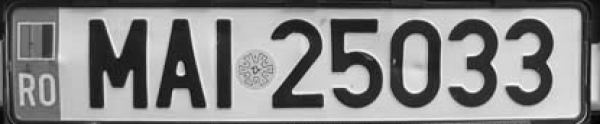

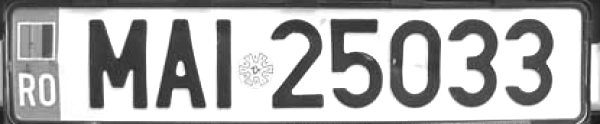

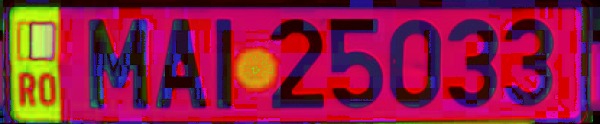

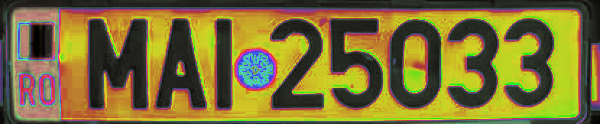

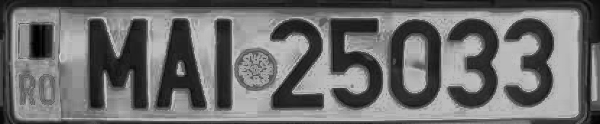

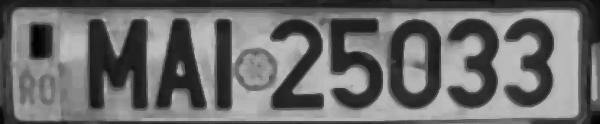

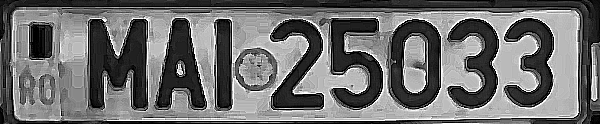

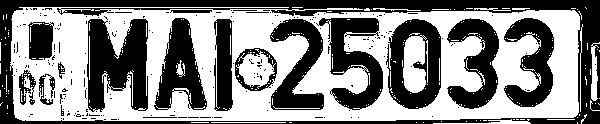

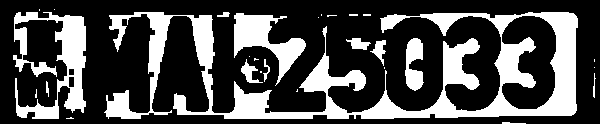

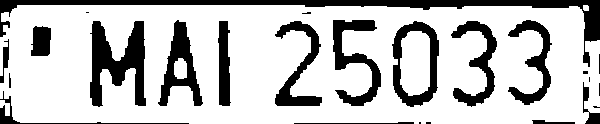

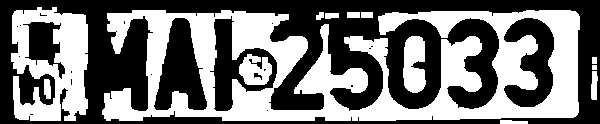

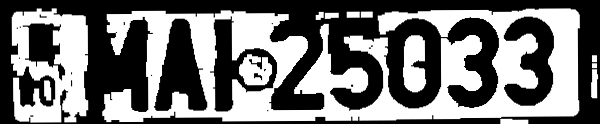

In [338]:
license_plate = imutils.resize(np.array(license_plate), width=600)
grayed_initial = get_grayscale(license_plate)

brightness = 50
contrast = 30
brightness_adjusted = np.int16(grayed_initial)
brightness_adjusted = brightness_adjusted * (contrast/127+1) - contrast + brightness
brightness_adjusted = np.clip(brightness_adjusted, 0, 255)
brightness_adjusted = np.uint8(brightness_adjusted)

if np.mean(grayed_initial) > 127:  # light image
    pass
else: # dark image
  pass
    
cv2_imshow(grayed_initial)
cv2_imshow(brightness_adjusted)

hsv = cv2.cvtColor(np.array(license_plate), cv2.COLOR_BGR2HSV)
bgr = cv2.cvtColor(np.array(license_plate), cv2.COLOR_HSV2BGR)
grayed = get_grayscale(bgr)
denoised = remove_noise(grayed, 5)
sharped = sharpen(denoised)
thresh = thresholding(sharped)
cv2_imshow(hsv)
cv2_imshow(bgr)
cv2_imshow(grayed)
cv2_imshow(denoised)
cv2_imshow(sharped)
cv2_imshow(thresh)


eroded = erode(thresh, (5, 5))
dilated = dilate(thresh, (5, 5))
opened = opening(thresh, (5, 5))

cv2_imshow(eroded)
cv2_imshow(dilated)
cv2_imshow(opened)

deskewed = deskew(opened)
cv2_imshow(deskewed)

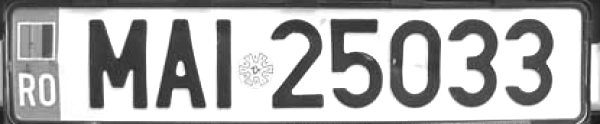

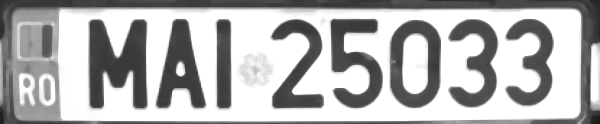

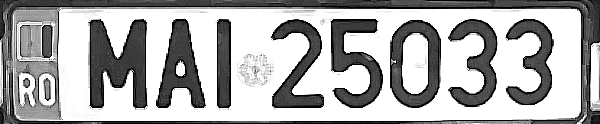

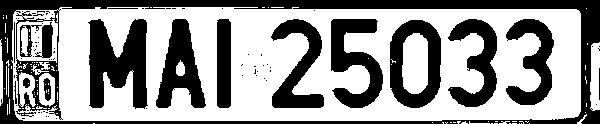

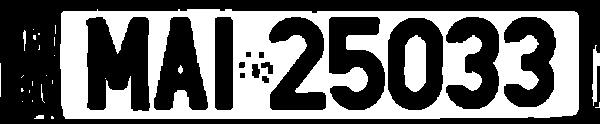

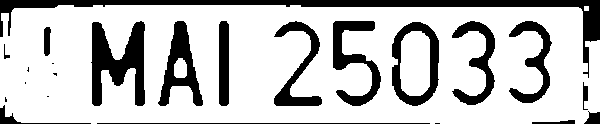

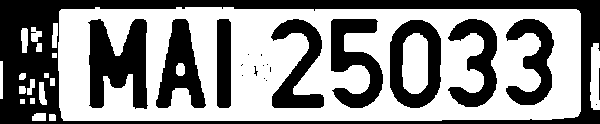

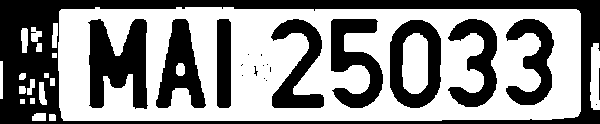

In [339]:
noised = remove_noise(brightness_adjusted, 5)
sharped = sharpen(noised)
thresh = thresholding(sharped)
cv2_imshow(brightness_adjusted)
cv2_imshow(noised)
cv2_imshow(sharped)
cv2_imshow(thresh)
eroded = erode(thresh, (5, 5))
dilated = dilate(thresh, (5, 5))
opened = opening(thresh, (5, 5))

cv2_imshow(eroded)
cv2_imshow(dilated)
cv2_imshow(opened)

deskewed = deskew(opened)
cv2_imshow(deskewed)

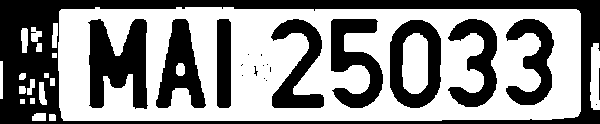

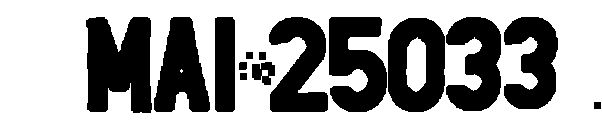

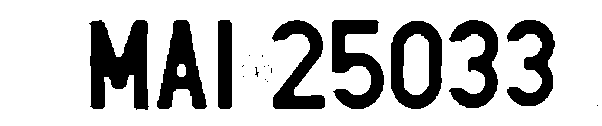

In [344]:
border_removed = cv2.copyMakeBorder(deskewed, 1, 1, 1, 1, cv2.BORDER_CONSTANT, (0, 0))
cv2.floodFill(border_removed, None, (0,0), 255)
eroded_border_removed = erode(border_removed, (7, 7))
cv2_imshow(deskewed)
cv2_imshow(eroded_border_removed)
cv2_imshow(border_removed)

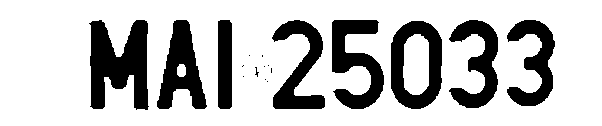

In [341]:
from math import floor
VERTICAL_THRESHOLD = 0.07 * border_removed.shape[0]
HORIZONTAL_THRESHOLD = 0.05 * border_removed.shape[1]
zeros = np.where(border_removed == 0)
border_removed_repeated = border_removed.copy()

border_removed_repeated[:floor(VERTICAL_THRESHOLD),:] = 255
border_removed_repeated[-floor(VERTICAL_THRESHOLD):,:] = 255
border_removed_repeated[:,:floor(HORIZONTAL_THRESHOLD)] = 255
border_removed_repeated[:,-floor(HORIZONTAL_THRESHOLD):] = 255
cv2_imshow(border_removed_repeated)

In [349]:
targets = {"grayed": grayed_initial,
           "brightness adjusted": brightness_adjusted,
           "denoised": denoised,
           "sharped": sharped, 
           "threshold": thresh, 
           "eroded": eroded, 
           "dilated": dilated,
           "opened": opened,
           "deskewed": deskewed,
           "border removed": border_removed,
           "eroded after border removed": eroded_border_removed,
           "border removed repeated": border_removed_repeated}

predictions = list()

for label, img in targets.items():
  prediction = reader.readtext(img, allowlist="QWERTYUIOPASDFGHJKLZXCVBNM1234567890") # detail=0
  predictions.append((img, label, prediction))

Prediction for grayed
IRO
MAI25033


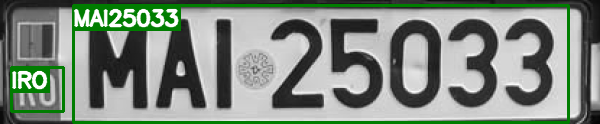

Prediction for brightness adjusted
IRO
MAI25033


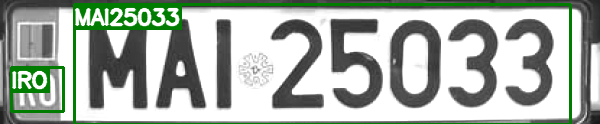

Prediction for denoised
R0
MAI25033


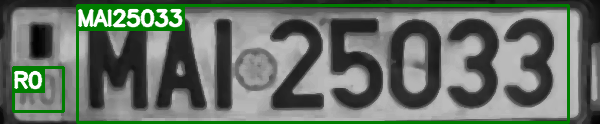

Prediction for sharped
O
MAI25033


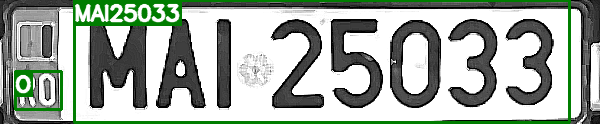

Prediction for threshold
MAI25033


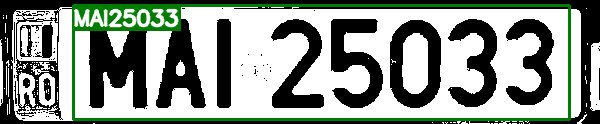

Prediction for eroded
MAI25033


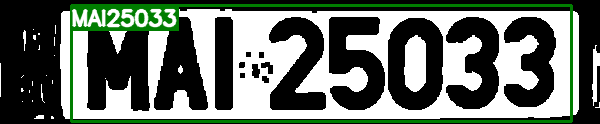

Prediction for dilated
MAI250337


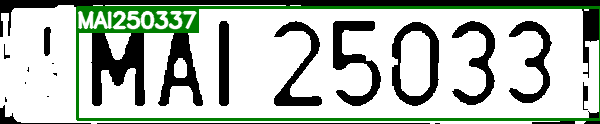

Prediction for opened
MAI25033


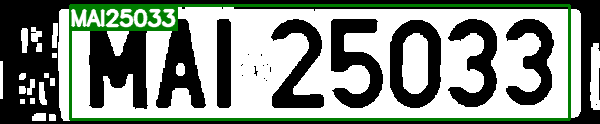

Prediction for deskewed
MAI25033


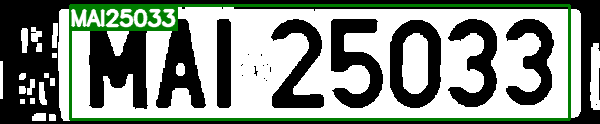

Prediction for border removed
MAI25033


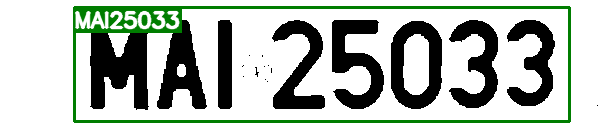

Prediction for eroded after border removed
MAI25033


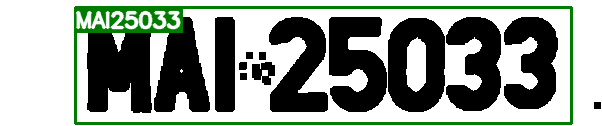

Prediction for border removed repeated
MAI25033


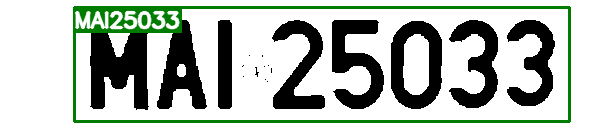

In [350]:
for img, label, prediction_segments in predictions:
  bgr_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  print(f"Prediction for {label}")
  for segment in prediction_segments:
    top_left, top_right, bottom_right, bottom_left = segment[0]
    top_left, bottom_right = tuple(map(int, top_left)), tuple(map(int,bottom_right))
    cv2.rectangle(bgr_img, top_left, bottom_right, (0, 125, 0), 2)

    label_start_pos = (top_left[0], top_left[1]+20)
    (w, h), _ = cv2.getTextSize(segment[1], cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
    cv2.rectangle(bgr_img, (label_start_pos[0], label_start_pos[1]-h-5),(label_start_pos[0]+w, label_start_pos[1]+5), (0, 125, 0), -1)
    cv2.putText(bgr_img, segment[1], label_start_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    print(segment[1])
  cv2_imshow(bgr_img)